<a href="https://colab.research.google.com/github/imnawar/CS664_Project/blob/main/CDM_for_Improved_ER_Using_FER2013_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional Diffusion Models for Improved Emotion Recognition Using FER2013


---


Manal Allahyani

Rahaf Alsulami

Renad Alsaidi


---

**King Abdulaziz University**

**Faculty of Computing and Information Systems**

**Spring 2025**


---


***CS664-Computer Vision***

**Course Project**

# Set the enviroment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install opendatasets

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
! pip install torch-fidelity

In [ ]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.6 MB/s eta 0:00:00


In [ ]:
!pip install torch torchvision scikit-learn

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# === Standard Libraries ===
import os
import json
import copy
import random
import shutil
from pathlib import Path
from zipfile import ZipFile

# === Numerical & Scientific Libraries ===
import numpy as np
from scipy import linalg
from scipy.linalg import sqrtm

# === Image Processing ===
from PIL import Image, ImageStat
from skimage import filters

# === Plotting & Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Progress Bar ===
from tqdm import tqdm

# === PyTorch Core ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset

# === Torchvision ===
from torchvision import datasets, transforms, models
from torchvision.models import inception_v3
from torchvision.transforms import RandomApply

# === TorchMetrics ===
import torchmetrics
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# === Diffusers (for diffusion models) ===
from diffusers import UNet2DModel, DDPMScheduler

# === Evaluation Metrics ===
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# === OpenDatasets (Kaggle datasets etc.) ===
import opendatasets as od

# === LPIPS Metric ===
import lpips


In [ ]:
# Data to be written
dictionary = {"username":"imanawar","key":"8a39e9fa45fc2924d031f36a89e8879d"}

with open("kaggle.json", "w") as outfile:
	json.dump(dictionary, outfile)

In [ ]:
!kaggle datasets download -d 'msambare/fer2013'

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 65% 39.0M/60.3M [00:00<00:00, 408MB/s]
100% 60.3M/60.3M [00:00<00:00, 260MB/s]


In [ ]:
def extract_data(zipfile_path: Path, destination_path: Path) -> None:
    '''Extracts zipfile'''

    if destination_path.is_dir():
        print(f"{destination_path} exists.")
    else:
        print(f"{destination_path} doesn't exist, creating one...")
        destination_path.mkdir(parents=True, exist_ok=True)

    if not os.listdir(destination_path):
        with ZipFile(zipfile_path, 'r') as zip:
            print("Extracting files...")
            zip.extractall(destination_path)

            print("Extracting finished.")
    else:
        print("Data already extracted.")

data_path = Path("/content")
zipfile_path = data_path / "/content/fer2013.zip"
images_path = data_path / "fer2013"

extract_data(zipfile_path, images_path)

/content/fer2013 doesn't exist, creating one...
Extracting files...
Extracting finished.


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Display class counts right after download
print("\n📊 Dataset Class Distribution:")
emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
counts = {}

# Count files in each class folder
for idx, emotion in enumerate(emotions):
    class_dir = os.path.join("fer2013/train", emotion)
    if os.path.exists(class_dir):
        num_files = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        counts[emotion] = num_files
        print(f"{emotion}: {num_files} images")
    else:
        counts[emotion] = 0
        print(f"{emotion}: 0 images (folder missing)")

# Visual representation
print("\n📈 Visual Representation:")
max_count = max(counts.values()) if counts else 1
for emotion, count in counts.items():
    bar = '█' * int(50 * count/max_count)
    print(f"{emotion.ljust(8)}: {bar} {count}")


📊 Dataset Class Distribution:
angry: 3995 images
disgust: 436 images
fear: 4097 images
happy: 7215 images
sad: 4830 images
surprise: 3171 images
neutral: 4965 images

📈 Visual Representation:
angry   : ███████████████████████████ 3995
disgust : ███ 436
fear    : ████████████████████████████ 4097
happy   : ██████████████████████████████████████████████████ 7215
sad     : █████████████████████████████████ 4830
surprise: █████████████████████ 3171
neutral : ██████████████████████████████████ 4965


In [ ]:
def show_emotion_grid(base_path="fer2013/train", emotions=None, images_per_class=2, image_size=(48, 48)):
    if emotions is None:
        emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    fig, axs = plt.subplots(images_per_class, len(emotions), figsize=(len(emotions) * 1.5, images_per_class * 1.5))

    for col, emotion in enumerate(emotions):
        class_path = os.path.join(base_path, emotion)
        files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        chosen_files = random.sample(files, images_per_class)

        for row in range(images_per_class):
            img_path = os.path.join(class_path, chosen_files[row])
            img = Image.open(img_path).convert('L').resize(image_size)
            axs[row, col].imshow(img, cmap='gray')
            axs[row, col].axis('off')

    # Add labels above each column
    for col, emotion in enumerate(emotions):
        axs[0, col].set_title(emotion.capitalize(), fontsize=12)

    plt.tight_layout()
    plt.show()


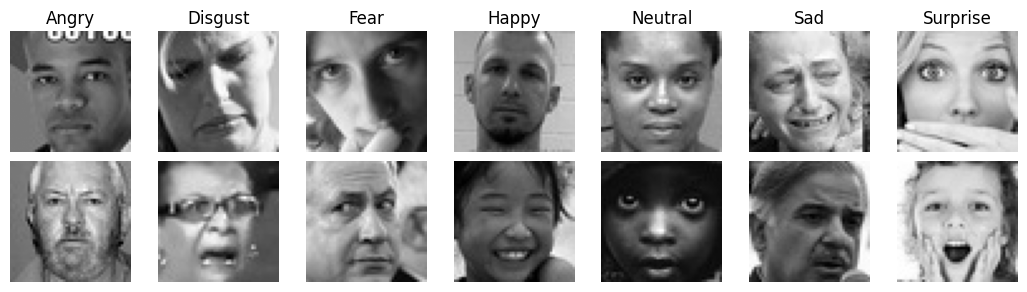

In [ ]:
show_emotion_grid("fer2013/train")

# Diffusion Model For Generating Data Without Fing-tuning

In [ ]:
# Load pretrained model from Hugging Face
model_id = "Ketansomewhere/FER_2013_Conditional_Diffusion"

In [ ]:
# Load the conditional UNet and scheduler
unet = UNet2DModel.from_pretrained(model_id, subfolder="unet").to(device)
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/456M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/512 [00:00<?, ?B/s]

## Generate Data

In [ ]:
# List of emotions (index must match class IDs used during training)
emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

def generate_images_for_class(class_id, num_images=100,
                               save_base="/content/generated_fer",
                               drive_base="/content/drive/MyDrive/generated_fer_surprice"):

    class_name = emotions[class_id]

    # Create output directories
    local_path = os.path.join(save_base, class_name)
    drive_path = os.path.join(drive_base, class_name)
    os.makedirs(local_path, exist_ok=True)
    os.makedirs(drive_path, exist_ok=True)

    scheduler.set_timesteps(1000)
    unet.eval()

    for i in tqdm(range(num_images), desc=f"Generating {class_name}"):
        x = torch.randn((1, 3, 32, 32)).to(device)
        label = torch.tensor([class_id]).to(device)

        for t in scheduler.timesteps:
            with torch.no_grad():
                noise_pred = unet(x, t, class_labels=label).sample
            x = scheduler.step(noise_pred, t, x).prev_sample

        # Convert and save image
        x_post = (x.squeeze().permute(1, 2, 0) / 2 + 0.5).clamp(0, 1)
        img_np = (x_post.cpu().numpy() * 255).astype(np.uint8)
        img_pil = Image.fromarray(img_np)

        img_pil.save(os.path.join(local_path, f"{class_name}_{i+713}.png"))
        img_pil.save(os.path.join(drive_path, f"{class_name}_{i+713}.png"))

    print(f"\n✅ Finished generating {num_images} images for class {class_name}!")

In [ ]:
# {class_id: {'name': class_name, 'count': image_count}}
class_info = {
    0: {'name': 'angry', 'count': 1500},
    1: {'name': 'disgust', 'count': 2000},
    2: {'name': 'fear', 'count': 1800},
    3: {'name': 'happy', 'count': 1200},
    4: {'name': 'sad', 'count': 2200},
    5: {'name': 'surprise', 'count': 2200},
    6: {'name': 'neutral', 'count': 2200},
}

# Loop through the dictionary and call the function
for class_id, info in class_info.items():
    generate_images_for_class(class_id=class_id, num_images=info['count'])

## Evaluating The Generated Data

***Metrics***

***FID*** : Measures how similar two groups of images are
Lower FID → generated images are closer to real images.
__________________
***IS*** : Measures both image quality and diversity.
Higher IS → images are sharp and diverse.

___________________________
***LPIPS*** :
Measures perceptual similarity between two images from a human vision point of view.
Lower LPIPS is better:

Lower LPIPS → generated images are more visually similar to real images.




In [ ]:
inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
inception_model.eval()
lpips_model = lpips.LPIPS(net='alex').to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 92.3MB/s]


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 53.9MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
fid_metric = torchmetrics.image.fid.FrechetInceptionDistance(feature=2048).to(device)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 40.0MB/s]


In [ ]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor()
])

def load_images(folder_path, num_images):
    images = []
    files = sorted(os.listdir(folder_path))[:num_images]
    for file in files:
        img = Image.open(os.path.join(folder_path, file)).convert('RGB')  # Convert to 3 channels
        img = transform(img)
        images.append(img)
    return images

In [ ]:
def evaluate_class(class_name, real_base, fake_base, num_images=100):
    print(f"\nEvaluating class: {class_name}")

    real_path = os.path.join(real_base, class_name)
    fake_path = os.path.join(fake_base, class_name)

    real_images = load_images(real_path, num_images)
    fake_images = load_images(fake_path, num_images)

    real_images = torch.stack(real_images).to(device)
    fake_images = torch.stack(fake_images).to(device)

    # print(f"Fake image pixel range: min = {fake_images.min().item():.4f}, max = {fake_images.max().item():.4f}")
    # print(f"real image pixel range: min = {real_images.min().item():.4f}, max = {real_images.max().item():.4f}")

    # ✅ Add shape check
    # print("Fake batch shape:", fake_images.shape)
    # print("Real batch shape:", real_images.shape)

    # Check pixel value range


    with torch.no_grad():
        # Inception Score
        pred = inception_model(fake_images)
        pred = torch.nn.functional.softmax(pred, dim=1)
        kl_div = pred * (pred.log() - pred.mean(dim=0).log())
        inception_score = torch.exp(kl_div.sum(1).mean())


        real_images_uint8 = real_images.clamp(0, 1).to(torch.uint8)
        fake_images_uint8 = fake_images.clamp(0, 1).to(torch.uint8)

        # print(f"Real image pixel range: min = {real_images_uint8.min().item():.4f}, max = {real_images_uint8.max().item():.4f}")
        # print(f"Fake image pixel range: min = {fake_images_uint8.min().item():.4f}, max = {fake_images_uint8.max().item():.4f}")

        # FID
        fid_metric.update(real_images_uint8, real=True)
        fid_metric.update(fake_images_uint8, real=False)
        fid_value = fid_metric.compute()
        fid_metric.reset()

        # LPIPS
        lpips_scores = []
        for real_img, fake_img in zip(real_images, fake_images):
            score = lpips_model(real_img.unsqueeze(0), fake_img.unsqueeze(0))
            lpips_scores.append(score.item())
        avg_lpips = sum(lpips_scores) / len(lpips_scores)

    print(f"  - Inception Score (IS): {inception_score:.4f}")
    print(f"  - Frechet Inception Distance (FID): {fid_value:.4f}")
    print(f"  - Average LPIPS Score: {avg_lpips:.6f}")


In [ ]:
#pathes
real_base_path = "/content/fer2013/train"
fake_base_path = "/content/generated_fer"

In [ ]:
#classes to evaluate it
classes_to_evaluate = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'] ### MAKE SURE FROM THESE CLASSES PLEASE

#evaluate each class
for class_name in classes_to_evaluate:
    evaluate_class(class_name, real_base=real_base_path, fake_base=fake_base_path, num_images=50)


Evaluating class: angry
Fake image pixel range: min = 0.0000, max = 1.0000
real image pixel range: min = 0.0000, max = 1.0000
Fake batch shape: torch.Size([50, 3, 299, 299])
Real batch shape: torch.Size([50, 3, 299, 299])
Real image pixel range: min = 0.0000, max = 1.0000
Fake image pixel range: min = 0.0000, max = 1.0000
  - Inception Score (IS): 2.2690
  - Frechet Inception Distance (FID): 0.8924
  - Average LPIPS Score: 0.439516

Evaluating class: disgust
Fake image pixel range: min = 0.0000, max = 1.0000
real image pixel range: min = 0.0000, max = 1.0000
Fake batch shape: torch.Size([50, 3, 299, 299])
Real batch shape: torch.Size([50, 3, 299, 299])
Real image pixel range: min = 0.0000, max = 1.0000
Fake image pixel range: min = 0.0000, max = 1.0000
  - Inception Score (IS): 1.9144
  - Frechet Inception Distance (FID): 0.5950
  - Average LPIPS Score: 0.420647

Evaluating class: surprise
Fake image pixel range: min = 0.0000, max = 1.0000
real image pixel range: min = 0.0000, max = 1

IS (Inception Score)	كلما كان أعلى كلما كان أفضل	,	يقيس وضوح وتنوع الصور. القيم بين 5 إلى 8 تعتبر جيدة غالبًا للوجوه، أقل من 3 تعتبر ضعيفة.
_______________________________________________
FID	كلما أقل كلما أفضل,	يقيس المسافة بين التوزيع الحقيقي والمولد. أقل من 50 يعتبر جيد. أقل من 20 ممتاز. أعلى من 100 يعني فرق كبير وجودة منخفضة.
__________________________________________
LPIPS	كلما أصغر كلما أفضل	. 	يقيس الفرق البصري بين الصور الحقيقية والمولدة. قريبة من 0 جيدة. قريبة من 1 تعني أن الصور مختلفة جدًا.


### Plotting the reuslts

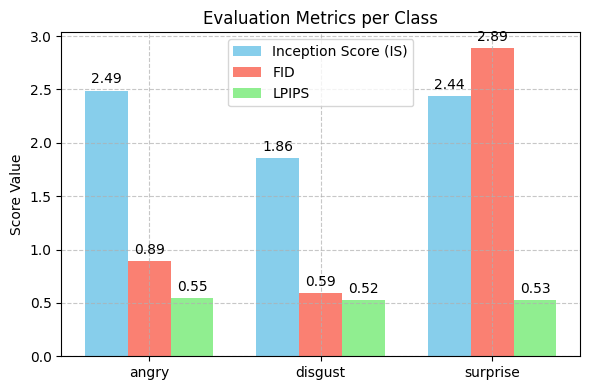

In [ ]:

# بيانات النتائج التي حصلت عليها
classes = ['angry', 'disgust', 'surprise']
inception_scores = [2.4890, 1.8594, 2.4375 ] # 2.2454, 2.0892, 2.4821
fid_scores = [0.8924, 0.5950, 2.8899] # 111.3347, 102.0025, 129.3807
lpips_scores = [0.546313, 0.524592, 0.527200] # 0.449877, 0.423640, 0.431796

x = np.arange(len(classes))  # مواقع الكلاسات
width = 0.25  # عرض الأعمدة

# رسم الرسم البياني
fig, ax1 = plt.subplots(figsize=(6, 4))

# رسم الأعمدة الثلاثة
rects1 = ax1.bar(x - width, inception_scores, width, label='Inception Score (IS)', color='skyblue')
rects2 = ax1.bar(x, fid_scores, width, label='FID', color='salmon')
rects3 = ax1.bar(x + width, lpips_scores, width, label='LPIPS', color='lightgreen')

# إضافة تفاصيل الرسم
ax1.set_ylabel('Score Value')
ax1.set_title('Evaluation Metrics per Class')
ax1.set_xticks(x)
ax1.set_xticklabels(classes)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# عرض القيم فوق الأعمدة
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax1.annotate(f'{height:.2f}',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()


***Show generated image***

In [ ]:
def show_generated_images_by_class(generated_base_path="/content/generated_fer",
                                    emotions=None,
                                    images_per_class=3,
                                    image_size=(48, 48)):
    if emotions is None:
        emotions = ['angry', 'disgust', 'surprise']

    fig, axs = plt.subplots(images_per_class, len(emotions), figsize=(len(emotions) * 1.5, images_per_class * 1.5))

    for col, emotion in enumerate(emotions):
        class_dir = os.path.join(generated_base_path, emotion)
        image_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        selected_files = random.sample(image_files, images_per_class)

        for row in range(images_per_class):
            img_path = os.path.join(class_dir, selected_files[row])
            img = Image.open(img_path).convert("L").resize(image_size)
            axs[row, col].imshow(img, cmap='gray')
            axs[row, col].axis('off')

        # Label at the top of each column
        axs[0, col].set_title(emotion.capitalize(), fontsize=12)

    plt.tight_layout()
    plt.show()

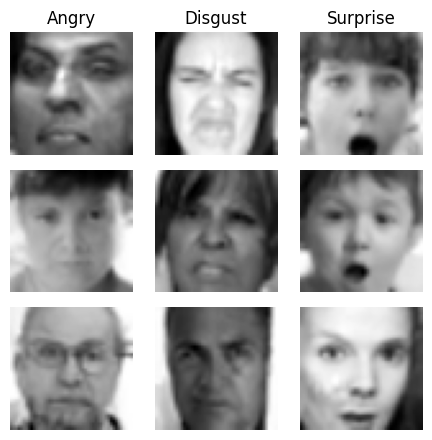

In [ ]:
show_generated_images_by_class(generated_base_path="/content/generated_fer")

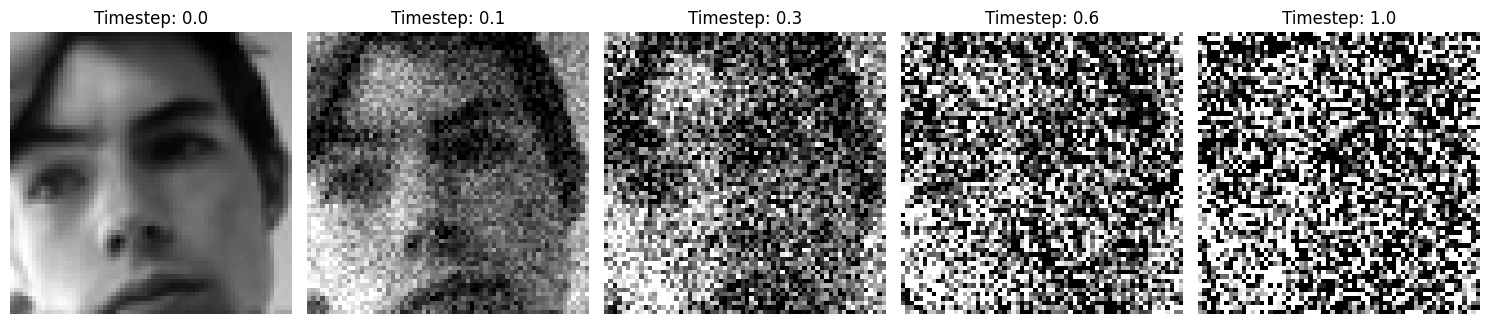

In [ ]:
# Step 1: Load one image from FER2013 dataset
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = ImageFolder(root="/content/fer2013", transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
img, label = next(iter(dataloader))  # shape: [1, 1, 48, 48]

# Step 2: Visualize noising process
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
noise_levels = [0.0, 0.1, 0.3, 0.6, 1.0]  # increasing noise

for idx, level in enumerate(noise_levels):
    noise = torch.randn_like(img) * level
    noisy_img = img + noise
    noisy_img = torch.clamp(noisy_img, 0., 1.)

    axes[idx].imshow(noisy_img.squeeze().cpu().numpy(), cmap='gray')
    axes[idx].set_title(f"Timestep: {level}")
    axes[idx].axis("off")

plt.tight_layout()
plt.show()


# Classifiers

## Prepare The Data

    dataset/
      train/
        class1/
        class2/
        ...
      val/
        class1/
        class2/
        ...


In [ ]:
# === CONFIG ===

zip_path = '/content/generated_data.zip'       # Path to your zip file
extract_dir = 'extracted_dataset'   # Destination directory
os.makedirs(extract_dir, exist_ok=True)

# === UNZIP ===
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Unzipped '{zip_path}' to '{extract_dir}'")


✅ Unzipped '/content/generated_data.zip' to 'extracted_dataset'


In [ ]:

# === CONFIG ===
original_dataset_dir = '/content/extracted_dataset/generated_data'  # Path to original images (class folders)
target_dataset_dir = 'dataset'                                      # Output root folder
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure split directories exist
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(target_dataset_dir, split), exist_ok=True)

# === PROCESS EACH CLASS ===
for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    total_images = len(images)
    train_end = int(total_images * train_ratio)
    val_end = train_end + int(total_images * val_ratio)

    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]

    # Copy to each split directory
    for split_name, split_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
        split_class_dir = os.path.join(target_dataset_dir, split_name, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for img_name in tqdm(split_images, desc=f"{split_name}/{class_name}"):
            src_path = os.path.join(class_path, img_name)
            dst_path = os.path.join(split_class_dir, img_name)
            shutil.copyfile(src_path, dst_path)

print("\n✅ Dataset split into 70% train, 15% val, 15% test.")

test/angry: 100%|██████████| 15/15 [00:00<00:00, 6945.75it/s]


✅ Dataset split into 70% train, 15% val, 15% test.


In [ ]:

# Paths
original_train_dir = '/content/fer2013/train'
original_test_dir = '/content/fer2013/test'
target_dataset_dir = 'dataset'

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

assert abs((train_ratio + val_ratio + test_ratio) - 1.0) < 1e-6, "Split ratios must sum to 1."

# Ensure target directories exist
for split in ['train', 'val', 'test']:
    split_path = os.path.join(target_dataset_dir, split)
    os.makedirs(split_path, exist_ok=True)

# Function to collect all images from a directory
def collect_images(base_dir):
    all_images = {}
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        if class_name not in all_images:
            all_images[class_name] = []
        all_images[class_name].extend([os.path.join(class_path, img) for img in images])

    return all_images

# Collect images from both train and test
images_from_train = collect_images(original_train_dir)
images_from_test = collect_images(original_test_dir)

# Merge images from both
all_images = {}
for class_name in set(images_from_train.keys()).union(images_from_test.keys()):
    all_images[class_name] = []
    all_images[class_name].extend(images_from_train.get(class_name, []))
    all_images[class_name].extend(images_from_test.get(class_name, []))

# Split and copy
for class_name, images in all_images.items():
    random.shuffle(images)
    total_images = len(images)
    train_end = int(total_images * train_ratio)
    val_end = train_end + int(total_images * val_ratio)

    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]

    for split, split_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
        split_class_dir = os.path.join(target_dataset_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for src_path in tqdm(split_images, desc=f"{split}/{class_name}"):
            img_name = os.path.basename(src_path)
            dst_path = os.path.join(split_class_dir, img_name)
            shutil.copyfile(src_path, dst_path)

print("\nDataset from both train and test folders combined and split into train, val, and test successfully.")


test/neutral: 100%|██████████| 931/931 [00:00<00:00, 8326.79it/s]


Dataset from both train and test folders combined and split into train, val, and test successfully.


In [ ]:
# Display class counts right after download
print("\n📊 Dataset Class Distribution:")
emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
counts = {}

# Count files in each class folder
for idx, emotion in enumerate(emotions):
    class_dir = os.path.join("/content/dataset/train", emotion)
    if os.path.exists(class_dir):
        num_files = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        counts[emotion] = num_files
        print(f"{emotion}: {num_files} images")
    else:
        counts[emotion] = 0
        print(f"{emotion}: 0 images (folder missing)")

# Visual representation
print("\n📈 Visual Representation:")
max_count = max(counts.values()) if counts else 1
for emotion, count in counts.items():
    bar = '█' * int(50 * count/max_count)
    print(f"{emotion.ljust(8)}: {bar} {count}")


📊 Dataset Class Distribution:
angry: 3537 images
disgust: 1504 images
fear: 3642 images
happy: 6292 images
sad: 4253 images
surprise: 3536 images
neutral: 4338 images

📈 Visual Representation:
angry   : ████████████████████████████ 3537
disgust : ███████████ 1504
fear    : ████████████████████████████ 3642
happy   : ██████████████████████████████████████████████████ 6292
sad     : █████████████████████████████████ 4253
surprise: ████████████████████████████ 3536
neutral : ██████████████████████████████████ 4338


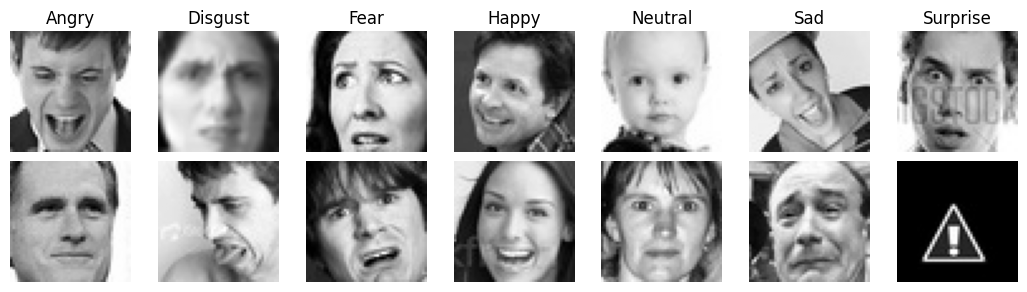

In [ ]:
show_emotion_grid("/content/dataset/train")

In [ ]:
# Paths
original_train_dir = '/content/fer2013/train'
original_test_dir = '/content/fer2013/test'
target_dataset_dir = 'original_dataset'

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

assert abs((train_ratio + val_ratio + test_ratio) - 1.0) < 1e-6, "Split ratios must sum to 1."

# Ensure target directories exist
for split in ['train', 'val', 'test']:
    split_path = os.path.join(target_dataset_dir, split)
    os.makedirs(split_path, exist_ok=True)

# Function to collect all images from a directory
def collect_images(base_dir):
    all_images = {}
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        if class_name not in all_images:
            all_images[class_name] = []
        all_images[class_name].extend([os.path.join(class_path, img) for img in images])

    return all_images

# Collect images from both train and test
images_from_train = collect_images(original_train_dir)
images_from_test = collect_images(original_test_dir)

# Merge images from both
all_images = {}
for class_name in set(images_from_train.keys()).union(images_from_test.keys()):
    all_images[class_name] = []
    all_images[class_name].extend(images_from_train.get(class_name, []))
    all_images[class_name].extend(images_from_test.get(class_name, []))

# Split and copy
for class_name, images in all_images.items():
    random.shuffle(images)
    total_images = len(images)
    train_end = int(total_images * train_ratio)
    val_end = train_end + int(total_images * val_ratio)

    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]

    for split, split_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
        split_class_dir = os.path.join(target_dataset_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for src_path in tqdm(split_images, desc=f"{split}/{class_name}"):
            img_name = os.path.basename(src_path)
            dst_path = os.path.join(split_class_dir, img_name)
            shutil.copyfile(src_path, dst_path)

print("\nDataset from both train and test folders combined and split into train, val, and test successfully.")


test/neutral: 100%|██████████| 931/931 [00:00<00:00, 6538.59it/s]


Dataset from both train and test folders combined and split into train, val, and test successfully.


In [ ]:
# Display class counts right after download
print("\n📊 Dataset Class Distribution:")
emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
counts = {}

# Count files in each class folder
for idx, emotion in enumerate(emotions):
    class_dir = os.path.join("/content/original_dataset/train", emotion)
    if os.path.exists(class_dir):
        num_files = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        counts[emotion] = num_files
        print(f"{emotion}: {num_files} images")
    else:
        counts[emotion] = 0
        print(f"{emotion}: 0 images (folder missing)")

# Visual representation
print("\n📈 Visual Representation:")
max_count = max(counts.values()) if counts else 1
for emotion, count in counts.items():
    bar = '█' * int(50 * count/max_count)
    print(f"{emotion.ljust(8)}: {bar} {count}")


📊 Dataset Class Distribution:
angry: 3467 images
disgust: 382 images
fear: 3584 images
happy: 6292 images
sad: 4253 images
surprise: 2801 images
neutral: 4338 images

📈 Visual Representation:
angry   : ███████████████████████████ 3467
disgust : ███ 382
fear    : ████████████████████████████ 3584
happy   : ██████████████████████████████████████████████████ 6292
sad     : █████████████████████████████████ 4253
surprise: ██████████████████████ 2801
neutral : ██████████████████████████████████ 4338


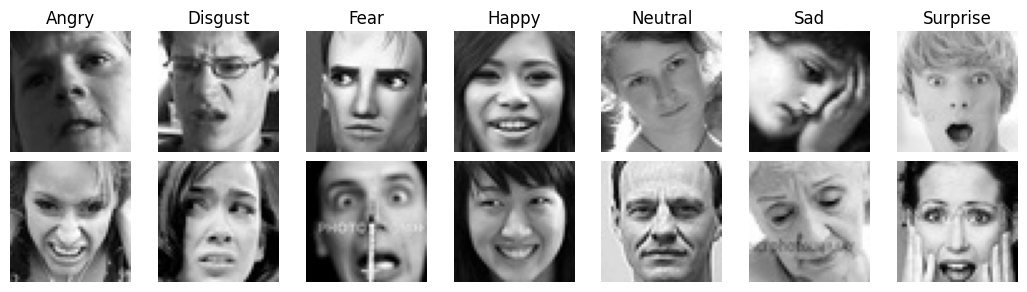

In [ ]:
show_emotion_grid("/content/original_dataset/train")

## CNN

**CNN ARCH**

In [ ]:
# === MODEL ===
class MultiClassCNN(nn.Module):
    def __init__(self, num_classes):
        super(MultiClassCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


**Training CONFIG**

In [ ]:
# === CONFIG ===

batch_size = 64
num_epochs = 100
learning_rate = 0.001


**Training Loop Function**

In [ ]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    for epoch in range(num_epochs):
        print(f"\n🌱 Epoch {epoch+1}/{num_epochs}")

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            loader = train_loader if phase == 'train' else val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(loader, desc=f"{phase.capitalize()}"):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels).sum().item()

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects / len(loader.dataset)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

    print("\n✅ Training complete.")


**Testing Function**

In [ ]:
def test_model(model, test_loader, criterion, device):
    print("\n🧪 Starting test phase...")
    model.eval()
    test_loss = 0.0
    test_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Test"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            test_corrects += (preds == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = test_corrects / len(test_loader.dataset)

    print(f"\n📊 Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

    return test_loss, test_acc


Testing: 100%|██████████| 182/182 [00:03<00:00, 59.77it/s]



🔍 Test Accuracy: 0.5721

📊 Classification Report:
              precision    recall  f1-score   support

       angry       0.42      0.45      0.44       759
     disgust       0.87      0.73      0.79       324
        fear       0.40      0.35      0.38       783
       happy       0.70      0.79      0.75      1349
     neutral       0.50      0.47      0.48       931
         sad       0.44      0.44      0.44       913
    surprise       0.76      0.75      0.75       760

    accuracy                           0.57      5819
   macro avg       0.59      0.57      0.58      5819
weighted avg       0.57      0.57      0.57      5819



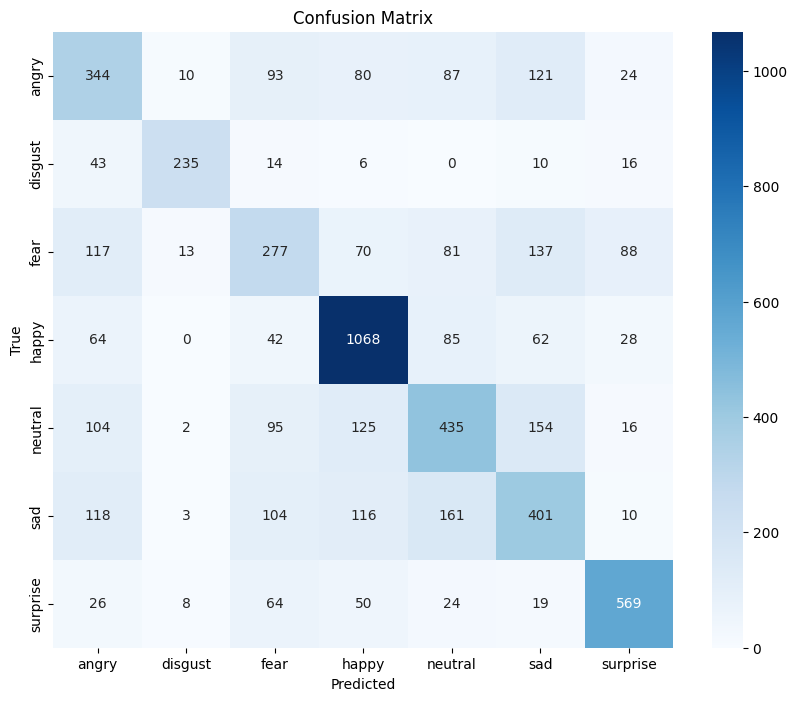

In [ ]:
def evaluate_model(model, test_loader, device, class_names):
    print("\n🧪 Starting evaluation phase...")
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # === METRICS ===
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n🔍 Test Accuracy: {acc:.4f}")

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return acc, cm


### CNN (GENERATED + REAL)

In [ ]:
# === TRANSFORMS ===
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

data_dir = 'dataset'

# === DATASETS ===
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

# === DATALOADERS ===
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# === CLASS INFO ===
num_classes = len(train_dataset.classes)
print("🔢 Detected classes:", train_dataset.classes)
print("🔢 Class-to-index mapping:", train_dataset.class_to_idx)
print("🔢 Number of classes:", num_classes)

**Create Model**

In [ ]:
cnn_generated_model = MultiClassCNN(num_classes).to(device)

# === LOSS & OPTIMIZER ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_generated_model.parameters(), lr=learning_rate)


**Training**

In [ ]:
train_and_validate(
    model=cnn_generated_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

🔢 Detected classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
🔢 Class-to-index mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
🔢 Number of classes: 7

🌱 Epoch 1/50


Train: 100%|██████████| 847/847 [00:25<00:00, 33.00it/s]


Train Loss: 1.7293 | Acc: 0.3124


Val: 100%|██████████| 182/182 [00:03<00:00, 47.26it/s]


Val Loss: 1.5673 | Acc: 0.4083

🌱 Epoch 2/50


Train: 100%|██████████| 847/847 [00:23<00:00, 35.86it/s]


Train Loss: 1.4491 | Acc: 0.4461


Val: 100%|██████████| 182/182 [00:03<00:00, 56.12it/s]


Val Loss: 1.3519 | Acc: 0.4843

🌱 Epoch 3/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.62it/s]


Train Loss: 1.3211 | Acc: 0.4994


Val: 100%|██████████| 182/182 [00:03<00:00, 58.15it/s]


Val Loss: 1.2686 | Acc: 0.5165

🌱 Epoch 4/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.45it/s]


Train Loss: 1.2392 | Acc: 0.5315


Val: 100%|██████████| 182/182 [00:03<00:00, 56.52it/s]


Val Loss: 1.2490 | Acc: 0.5245

🌱 Epoch 5/50


Train: 100%|██████████| 847/847 [00:23<00:00, 35.91it/s]


Train Loss: 1.1771 | Acc: 0.5555


Val: 100%|██████████| 182/182 [00:03<00:00, 57.86it/s]


Val Loss: 1.1989 | Acc: 0.5427

🌱 Epoch 6/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.09it/s]


Train Loss: 1.1114 | Acc: 0.5797


Val: 100%|██████████| 182/182 [00:03<00:00, 49.54it/s]


Val Loss: 1.1948 | Acc: 0.5501

🌱 Epoch 7/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.62it/s]


Train Loss: 1.0523 | Acc: 0.5996


Val: 100%|██████████| 182/182 [00:03<00:00, 55.54it/s]


Val Loss: 1.1859 | Acc: 0.5584

🌱 Epoch 8/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.37it/s]


Train Loss: 0.9973 | Acc: 0.6211


Val: 100%|██████████| 182/182 [00:03<00:00, 58.11it/s]


Val Loss: 1.2006 | Acc: 0.5589

🌱 Epoch 9/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.46it/s]


Train Loss: 0.9457 | Acc: 0.6392


Val: 100%|██████████| 182/182 [00:03<00:00, 57.69it/s]


Val Loss: 1.1882 | Acc: 0.5603

🌱 Epoch 10/50


Train: 100%|██████████| 847/847 [00:23<00:00, 35.70it/s]


Train Loss: 0.8918 | Acc: 0.6564


Val: 100%|██████████| 182/182 [00:03<00:00, 58.08it/s]


Val Loss: 1.1925 | Acc: 0.5687

🌱 Epoch 11/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.70it/s]


Train Loss: 0.8418 | Acc: 0.6773


Val: 100%|██████████| 182/182 [00:03<00:00, 49.87it/s]


Val Loss: 1.2660 | Acc: 0.5717

🌱 Epoch 12/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.29it/s]


Train Loss: 0.7987 | Acc: 0.6890


Val: 100%|██████████| 182/182 [00:03<00:00, 50.91it/s]


Val Loss: 1.2768 | Acc: 0.5598

🌱 Epoch 13/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.59it/s]


Train Loss: 0.7510 | Acc: 0.7098


Val: 100%|██████████| 182/182 [00:03<00:00, 58.15it/s]


Val Loss: 1.3124 | Acc: 0.5701

🌱 Epoch 14/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.51it/s]


Train Loss: 0.7142 | Acc: 0.7195


Val: 100%|██████████| 182/182 [00:03<00:00, 58.54it/s]


Val Loss: 1.3704 | Acc: 0.5622

🌱 Epoch 15/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.42it/s]


Train Loss: 0.6739 | Acc: 0.7361


Val: 100%|██████████| 182/182 [00:03<00:00, 58.71it/s]


Val Loss: 1.4110 | Acc: 0.5619

🌱 Epoch 16/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.28it/s]


Train Loss: 0.6479 | Acc: 0.7449


Val: 100%|██████████| 182/182 [00:03<00:00, 57.99it/s]


Val Loss: 1.4617 | Acc: 0.5662

🌱 Epoch 17/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.07it/s]


Train Loss: 0.6114 | Acc: 0.7581


Val: 100%|██████████| 182/182 [00:03<00:00, 50.29it/s]


Val Loss: 1.5828 | Acc: 0.5639

🌱 Epoch 18/50


Train: 100%|██████████| 847/847 [00:21<00:00, 38.54it/s]


Train Loss: 0.5874 | Acc: 0.7647


Val: 100%|██████████| 182/182 [00:03<00:00, 52.41it/s]


Val Loss: 1.5743 | Acc: 0.5698

🌱 Epoch 19/50


Train: 100%|██████████| 847/847 [00:21<00:00, 38.57it/s]


Train Loss: 0.5674 | Acc: 0.7761


Val: 100%|██████████| 182/182 [00:03<00:00, 57.75it/s]


Val Loss: 1.6012 | Acc: 0.5636

🌱 Epoch 20/50


Train: 100%|██████████| 847/847 [00:21<00:00, 38.54it/s]


Train Loss: 0.5499 | Acc: 0.7771


Val: 100%|██████████| 182/182 [00:03<00:00, 60.32it/s]


Val Loss: 1.6529 | Acc: 0.5722

🌱 Epoch 21/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.59it/s]


Train Loss: 0.5207 | Acc: 0.7905


Val: 100%|██████████| 182/182 [00:03<00:00, 60.62it/s]


Val Loss: 1.6879 | Acc: 0.5567

🌱 Epoch 22/50


Train: 100%|██████████| 847/847 [00:22<00:00, 38.27it/s]


Train Loss: 0.5142 | Acc: 0.7957


Val: 100%|██████████| 182/182 [00:02<00:00, 60.99it/s]


Val Loss: 1.8238 | Acc: 0.5684

🌱 Epoch 23/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.27it/s]


Train Loss: 0.4996 | Acc: 0.7985


Val: 100%|██████████| 182/182 [00:03<00:00, 58.50it/s]


Val Loss: 1.7902 | Acc: 0.5681

🌱 Epoch 24/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.07it/s]


Train Loss: 0.4805 | Acc: 0.8033


Val: 100%|██████████| 182/182 [00:03<00:00, 60.26it/s]


Val Loss: 1.8832 | Acc: 0.5598

🌱 Epoch 25/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.69it/s]


Train Loss: 0.4633 | Acc: 0.8102


Val: 100%|██████████| 182/182 [00:03<00:00, 48.52it/s]


Val Loss: 1.9548 | Acc: 0.5631

🌱 Epoch 26/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.11it/s]


Train Loss: 0.4570 | Acc: 0.8160


Val: 100%|██████████| 182/182 [00:03<00:00, 52.29it/s]


Val Loss: 1.9272 | Acc: 0.5646

🌱 Epoch 27/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.48it/s]


Train Loss: 0.4471 | Acc: 0.8197


Val: 100%|██████████| 182/182 [00:03<00:00, 56.14it/s]


Val Loss: 1.9692 | Acc: 0.5637

🌱 Epoch 28/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.01it/s]


Train Loss: 0.4387 | Acc: 0.8210


Val: 100%|██████████| 182/182 [00:03<00:00, 58.50it/s]


Val Loss: 2.0034 | Acc: 0.5632

🌱 Epoch 29/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.49it/s]


Train Loss: 0.4243 | Acc: 0.8252


Val: 100%|██████████| 182/182 [00:03<00:00, 58.13it/s]


Val Loss: 2.0483 | Acc: 0.5606

🌱 Epoch 30/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.04it/s]


Train Loss: 0.4223 | Acc: 0.8274


Val: 100%|██████████| 182/182 [00:03<00:00, 53.90it/s]


Val Loss: 2.1410 | Acc: 0.5651

🌱 Epoch 31/50


Train: 100%|██████████| 847/847 [00:21<00:00, 38.56it/s]


Train Loss: 0.4070 | Acc: 0.8320


Val: 100%|██████████| 182/182 [00:03<00:00, 50.70it/s]


Val Loss: 2.1604 | Acc: 0.5622

🌱 Epoch 32/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.68it/s]


Train Loss: 0.3999 | Acc: 0.8371


Val: 100%|██████████| 182/182 [00:03<00:00, 50.97it/s]


Val Loss: 2.1093 | Acc: 0.5622

🌱 Epoch 33/50


Train: 100%|██████████| 847/847 [00:21<00:00, 38.66it/s]


Train Loss: 0.3993 | Acc: 0.8381


Val: 100%|██████████| 182/182 [00:03<00:00, 54.02it/s]


Val Loss: 2.2570 | Acc: 0.5662

🌱 Epoch 34/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.04it/s]


Train Loss: 0.3871 | Acc: 0.8426


Val: 100%|██████████| 182/182 [00:03<00:00, 57.78it/s]


Val Loss: 2.2966 | Acc: 0.5725

🌱 Epoch 35/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.62it/s]


Train Loss: 0.3779 | Acc: 0.8441


Val: 100%|██████████| 182/182 [00:03<00:00, 57.41it/s]


Val Loss: 2.4501 | Acc: 0.5651

🌱 Epoch 36/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.13it/s]


Train Loss: 0.3736 | Acc: 0.8500


Val: 100%|██████████| 182/182 [00:03<00:00, 58.77it/s]


Val Loss: 2.4618 | Acc: 0.5634

🌱 Epoch 37/50


Train: 100%|██████████| 847/847 [00:22<00:00, 36.83it/s]


Train Loss: 0.3746 | Acc: 0.8493


Val: 100%|██████████| 182/182 [00:03<00:00, 58.11it/s]


Val Loss: 2.5169 | Acc: 0.5622

🌱 Epoch 38/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.42it/s]


Train Loss: 0.3637 | Acc: 0.8519


Val: 100%|██████████| 182/182 [00:03<00:00, 50.49it/s]


Val Loss: 2.4263 | Acc: 0.5612

🌱 Epoch 39/50


Train: 100%|██████████| 847/847 [00:22<00:00, 38.40it/s]


Train Loss: 0.3573 | Acc: 0.8537


Val: 100%|██████████| 182/182 [00:03<00:00, 49.48it/s]


Val Loss: 2.3678 | Acc: 0.5582

🌱 Epoch 40/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.22it/s]


Train Loss: 0.3615 | Acc: 0.8543


Val: 100%|██████████| 182/182 [00:03<00:00, 58.95it/s]


Val Loss: 2.3535 | Acc: 0.5581

🌱 Epoch 41/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.60it/s]


Train Loss: 0.3447 | Acc: 0.8612


Val: 100%|██████████| 182/182 [00:03<00:00, 59.19it/s]


Val Loss: 2.3329 | Acc: 0.5622

🌱 Epoch 42/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.88it/s]


Train Loss: 0.3433 | Acc: 0.8609


Val: 100%|██████████| 182/182 [00:03<00:00, 58.29it/s]


Val Loss: 2.6746 | Acc: 0.5689

🌱 Epoch 43/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.05it/s]


Train Loss: 0.3402 | Acc: 0.8643


Val: 100%|██████████| 182/182 [00:03<00:00, 59.14it/s]


Val Loss: 2.5002 | Acc: 0.5634

🌱 Epoch 44/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.77it/s]


Train Loss: 0.3353 | Acc: 0.8628


Val: 100%|██████████| 182/182 [00:03<00:00, 58.68it/s]


Val Loss: 2.4964 | Acc: 0.5625

🌱 Epoch 45/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.78it/s]


Train Loss: 0.3347 | Acc: 0.8627


Val: 100%|██████████| 182/182 [00:03<00:00, 49.19it/s]


Val Loss: 2.6400 | Acc: 0.5634

🌱 Epoch 46/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.57it/s]


Train Loss: 0.3372 | Acc: 0.8634


Val: 100%|██████████| 182/182 [00:03<00:00, 53.30it/s]


Val Loss: 2.5619 | Acc: 0.5653

🌱 Epoch 47/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.10it/s]


Train Loss: 0.3320 | Acc: 0.8651


Val: 100%|██████████| 182/182 [00:03<00:00, 59.02it/s]


Val Loss: 2.5111 | Acc: 0.5694

🌱 Epoch 48/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.10it/s]


Train Loss: 0.3234 | Acc: 0.8704


Val: 100%|██████████| 182/182 [00:03<00:00, 59.80it/s]


Val Loss: 2.8054 | Acc: 0.5710

🌱 Epoch 49/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.81it/s]


Train Loss: 0.3215 | Acc: 0.8679


Val: 100%|██████████| 182/182 [00:03<00:00, 58.72it/s]


Val Loss: 2.6001 | Acc: 0.5658

🌱 Epoch 50/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.51it/s]


Train Loss: 0.3150 | Acc: 0.8706


Val: 100%|██████████| 182/182 [00:03<00:00, 57.23it/s]


Val Loss: 2.6901 | Acc: 0.5693

✅ Training complete.

🧪 Starting test phase...


Test: 100%|██████████| 182/182 [00:03<00:00, 48.15it/s]


📊 Test Loss: 2.6613 | Test Accuracy: 0.5721


**Testing and Evaluating**

In [ ]:
test_loss, test_acc = test_model(
    model=cnn_generated_model,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

# Evaluate and visualize
test_acc, conf_matrix = evaluate_model(
    model=cnn_generated_model,
    test_loader=test_loader,
    device=device,
    class_names=test_dataset.classes
)

### CNN (Real)

In [ ]:
# === TRANSFORMS ===
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

data_dir = 'original_dataset'

# === DATASETS ===
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

# === DATALOADERS ===
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# === CLASS INFO ===
num_classes = len(train_dataset.classes)
print("🔢 Detected classes:", train_dataset.classes)
print("🔢 Class-to-index mapping:", train_dataset.class_to_idx)
print("🔢 Number of classes:", num_classes)

**Create Model**

In [ ]:
cnn_real_model = MultiClassCNN(num_classes).to(device)

# === LOSS & OPTIMIZER ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_real_model.parameters(), lr=learning_rate)


**Training**

In [ ]:
train_and_validate(
    model=cnn_real_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

🔢 Detected classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
🔢 Class-to-index mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
🔢 Number of classes: 7

🌱 Epoch 1/50


Train: 100%|██████████| 847/847 [00:25<00:00, 33.00it/s]


Train Loss: 1.7293 | Acc: 0.3124


Val: 100%|██████████| 182/182 [00:03<00:00, 47.26it/s]


Val Loss: 1.5673 | Acc: 0.4083

🌱 Epoch 2/50


Train: 100%|██████████| 847/847 [00:23<00:00, 35.86it/s]


Train Loss: 1.4491 | Acc: 0.4461


Val: 100%|██████████| 182/182 [00:03<00:00, 56.12it/s]


Val Loss: 1.3519 | Acc: 0.4843

🌱 Epoch 3/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.62it/s]


Train Loss: 1.3211 | Acc: 0.4994


Val: 100%|██████████| 182/182 [00:03<00:00, 58.15it/s]


Val Loss: 1.2686 | Acc: 0.5165

🌱 Epoch 4/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.45it/s]


Train Loss: 1.2392 | Acc: 0.5315


Val: 100%|██████████| 182/182 [00:03<00:00, 56.52it/s]


Val Loss: 1.2490 | Acc: 0.5245

🌱 Epoch 5/50


Train: 100%|██████████| 847/847 [00:23<00:00, 35.91it/s]


Train Loss: 1.1771 | Acc: 0.5555


Val: 100%|██████████| 182/182 [00:03<00:00, 57.86it/s]


Val Loss: 1.1989 | Acc: 0.5427

🌱 Epoch 6/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.09it/s]


Train Loss: 1.1114 | Acc: 0.5797


Val: 100%|██████████| 182/182 [00:03<00:00, 49.54it/s]


Val Loss: 1.1948 | Acc: 0.5501

🌱 Epoch 7/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.62it/s]


Train Loss: 1.0523 | Acc: 0.5996


Val: 100%|██████████| 182/182 [00:03<00:00, 55.54it/s]


Val Loss: 1.1859 | Acc: 0.5584

🌱 Epoch 8/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.37it/s]


Train Loss: 0.9973 | Acc: 0.6211


Val: 100%|██████████| 182/182 [00:03<00:00, 58.11it/s]


Val Loss: 1.2006 | Acc: 0.5589

🌱 Epoch 9/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.46it/s]


Train Loss: 0.9457 | Acc: 0.6392


Val: 100%|██████████| 182/182 [00:03<00:00, 57.69it/s]


Val Loss: 1.1882 | Acc: 0.5603

🌱 Epoch 10/50


Train: 100%|██████████| 847/847 [00:23<00:00, 35.70it/s]


Train Loss: 0.8918 | Acc: 0.6564


Val: 100%|██████████| 182/182 [00:03<00:00, 58.08it/s]


Val Loss: 1.1925 | Acc: 0.5687

🌱 Epoch 11/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.70it/s]


Train Loss: 0.8418 | Acc: 0.6773


Val: 100%|██████████| 182/182 [00:03<00:00, 49.87it/s]


Val Loss: 1.2660 | Acc: 0.5717

🌱 Epoch 12/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.29it/s]


Train Loss: 0.7987 | Acc: 0.6890


Val: 100%|██████████| 182/182 [00:03<00:00, 50.91it/s]


Val Loss: 1.2768 | Acc: 0.5598

🌱 Epoch 13/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.59it/s]


Train Loss: 0.7510 | Acc: 0.7098


Val: 100%|██████████| 182/182 [00:03<00:00, 58.15it/s]


Val Loss: 1.3124 | Acc: 0.5701

🌱 Epoch 14/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.51it/s]


Train Loss: 0.7142 | Acc: 0.7195


Val: 100%|██████████| 182/182 [00:03<00:00, 58.54it/s]


Val Loss: 1.3704 | Acc: 0.5622

🌱 Epoch 15/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.42it/s]


Train Loss: 0.6739 | Acc: 0.7361


Val: 100%|██████████| 182/182 [00:03<00:00, 58.71it/s]


Val Loss: 1.4110 | Acc: 0.5619

🌱 Epoch 16/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.28it/s]


Train Loss: 0.6479 | Acc: 0.7449


Val: 100%|██████████| 182/182 [00:03<00:00, 57.99it/s]


Val Loss: 1.4617 | Acc: 0.5662

🌱 Epoch 17/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.07it/s]


Train Loss: 0.6114 | Acc: 0.7581


Val: 100%|██████████| 182/182 [00:03<00:00, 50.29it/s]


Val Loss: 1.5828 | Acc: 0.5639

🌱 Epoch 18/50


Train: 100%|██████████| 847/847 [00:21<00:00, 38.54it/s]


Train Loss: 0.5874 | Acc: 0.7647


Val: 100%|██████████| 182/182 [00:03<00:00, 52.41it/s]


Val Loss: 1.5743 | Acc: 0.5698

🌱 Epoch 19/50


Train: 100%|██████████| 847/847 [00:21<00:00, 38.57it/s]


Train Loss: 0.5674 | Acc: 0.7761


Val: 100%|██████████| 182/182 [00:03<00:00, 57.75it/s]


Val Loss: 1.6012 | Acc: 0.5636

🌱 Epoch 20/50


Train: 100%|██████████| 847/847 [00:21<00:00, 38.54it/s]


Train Loss: 0.5499 | Acc: 0.7771


Val: 100%|██████████| 182/182 [00:03<00:00, 60.32it/s]


Val Loss: 1.6529 | Acc: 0.5722

🌱 Epoch 21/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.59it/s]


Train Loss: 0.5207 | Acc: 0.7905


Val: 100%|██████████| 182/182 [00:03<00:00, 60.62it/s]


Val Loss: 1.6879 | Acc: 0.5567

🌱 Epoch 22/50


Train: 100%|██████████| 847/847 [00:22<00:00, 38.27it/s]


Train Loss: 0.5142 | Acc: 0.7957


Val: 100%|██████████| 182/182 [00:02<00:00, 60.99it/s]


Val Loss: 1.8238 | Acc: 0.5684

🌱 Epoch 23/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.27it/s]


Train Loss: 0.4996 | Acc: 0.7985


Val: 100%|██████████| 182/182 [00:03<00:00, 58.50it/s]


Val Loss: 1.7902 | Acc: 0.5681

🌱 Epoch 24/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.07it/s]


Train Loss: 0.4805 | Acc: 0.8033


Val: 100%|██████████| 182/182 [00:03<00:00, 60.26it/s]


Val Loss: 1.8832 | Acc: 0.5598

🌱 Epoch 25/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.69it/s]


Train Loss: 0.4633 | Acc: 0.8102


Val: 100%|██████████| 182/182 [00:03<00:00, 48.52it/s]


Val Loss: 1.9548 | Acc: 0.5631

🌱 Epoch 26/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.11it/s]


Train Loss: 0.4570 | Acc: 0.8160


Val: 100%|██████████| 182/182 [00:03<00:00, 52.29it/s]


Val Loss: 1.9272 | Acc: 0.5646

🌱 Epoch 27/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.48it/s]


Train Loss: 0.4471 | Acc: 0.8197


Val: 100%|██████████| 182/182 [00:03<00:00, 56.14it/s]


Val Loss: 1.9692 | Acc: 0.5637

🌱 Epoch 28/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.01it/s]


Train Loss: 0.4387 | Acc: 0.8210


Val: 100%|██████████| 182/182 [00:03<00:00, 58.50it/s]


Val Loss: 2.0034 | Acc: 0.5632

🌱 Epoch 29/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.49it/s]


Train Loss: 0.4243 | Acc: 0.8252


Val: 100%|██████████| 182/182 [00:03<00:00, 58.13it/s]


Val Loss: 2.0483 | Acc: 0.5606

🌱 Epoch 30/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.04it/s]


Train Loss: 0.4223 | Acc: 0.8274


Val: 100%|██████████| 182/182 [00:03<00:00, 53.90it/s]


Val Loss: 2.1410 | Acc: 0.5651

🌱 Epoch 31/50


Train: 100%|██████████| 847/847 [00:21<00:00, 38.56it/s]


Train Loss: 0.4070 | Acc: 0.8320


Val: 100%|██████████| 182/182 [00:03<00:00, 50.70it/s]


Val Loss: 2.1604 | Acc: 0.5622

🌱 Epoch 32/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.68it/s]


Train Loss: 0.3999 | Acc: 0.8371


Val: 100%|██████████| 182/182 [00:03<00:00, 50.97it/s]


Val Loss: 2.1093 | Acc: 0.5622

🌱 Epoch 33/50


Train: 100%|██████████| 847/847 [00:21<00:00, 38.66it/s]


Train Loss: 0.3993 | Acc: 0.8381


Val: 100%|██████████| 182/182 [00:03<00:00, 54.02it/s]


Val Loss: 2.2570 | Acc: 0.5662

🌱 Epoch 34/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.04it/s]


Train Loss: 0.3871 | Acc: 0.8426


Val: 100%|██████████| 182/182 [00:03<00:00, 57.78it/s]


Val Loss: 2.2966 | Acc: 0.5725

🌱 Epoch 35/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.62it/s]


Train Loss: 0.3779 | Acc: 0.8441


Val: 100%|██████████| 182/182 [00:03<00:00, 57.41it/s]


Val Loss: 2.4501 | Acc: 0.5651

🌱 Epoch 36/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.13it/s]


Train Loss: 0.3736 | Acc: 0.8500


Val: 100%|██████████| 182/182 [00:03<00:00, 58.77it/s]


Val Loss: 2.4618 | Acc: 0.5634

🌱 Epoch 37/50


Train: 100%|██████████| 847/847 [00:22<00:00, 36.83it/s]


Train Loss: 0.3746 | Acc: 0.8493


Val: 100%|██████████| 182/182 [00:03<00:00, 58.11it/s]


Val Loss: 2.5169 | Acc: 0.5622

🌱 Epoch 38/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.42it/s]


Train Loss: 0.3637 | Acc: 0.8519


Val: 100%|██████████| 182/182 [00:03<00:00, 50.49it/s]


Val Loss: 2.4263 | Acc: 0.5612

🌱 Epoch 39/50


Train: 100%|██████████| 847/847 [00:22<00:00, 38.40it/s]


Train Loss: 0.3573 | Acc: 0.8537


Val: 100%|██████████| 182/182 [00:03<00:00, 49.48it/s]


Val Loss: 2.3678 | Acc: 0.5582

🌱 Epoch 40/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.22it/s]


Train Loss: 0.3615 | Acc: 0.8543


Val: 100%|██████████| 182/182 [00:03<00:00, 58.95it/s]


Val Loss: 2.3535 | Acc: 0.5581

🌱 Epoch 41/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.60it/s]


Train Loss: 0.3447 | Acc: 0.8612


Val: 100%|██████████| 182/182 [00:03<00:00, 59.19it/s]


Val Loss: 2.3329 | Acc: 0.5622

🌱 Epoch 42/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.88it/s]


Train Loss: 0.3433 | Acc: 0.8609


Val: 100%|██████████| 182/182 [00:03<00:00, 58.29it/s]


Val Loss: 2.6746 | Acc: 0.5689

🌱 Epoch 43/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.05it/s]


Train Loss: 0.3402 | Acc: 0.8643


Val: 100%|██████████| 182/182 [00:03<00:00, 59.14it/s]


Val Loss: 2.5002 | Acc: 0.5634

🌱 Epoch 44/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.77it/s]


Train Loss: 0.3353 | Acc: 0.8628


Val: 100%|██████████| 182/182 [00:03<00:00, 58.68it/s]


Val Loss: 2.4964 | Acc: 0.5625

🌱 Epoch 45/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.78it/s]


Train Loss: 0.3347 | Acc: 0.8627


Val: 100%|██████████| 182/182 [00:03<00:00, 49.19it/s]


Val Loss: 2.6400 | Acc: 0.5634

🌱 Epoch 46/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.57it/s]


Train Loss: 0.3372 | Acc: 0.8634


Val: 100%|██████████| 182/182 [00:03<00:00, 53.30it/s]


Val Loss: 2.5619 | Acc: 0.5653

🌱 Epoch 47/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.10it/s]


Train Loss: 0.3320 | Acc: 0.8651


Val: 100%|██████████| 182/182 [00:03<00:00, 59.02it/s]


Val Loss: 2.5111 | Acc: 0.5694

🌱 Epoch 48/50


Train: 100%|██████████| 847/847 [00:22<00:00, 37.10it/s]


Train Loss: 0.3234 | Acc: 0.8704


Val: 100%|██████████| 182/182 [00:03<00:00, 59.80it/s]


Val Loss: 2.8054 | Acc: 0.5710

🌱 Epoch 49/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.81it/s]


Train Loss: 0.3215 | Acc: 0.8679


Val: 100%|██████████| 182/182 [00:03<00:00, 58.72it/s]


Val Loss: 2.6001 | Acc: 0.5658

🌱 Epoch 50/50


Train: 100%|██████████| 847/847 [00:23<00:00, 36.51it/s]


Train Loss: 0.3150 | Acc: 0.8706


Val: 100%|██████████| 182/182 [00:03<00:00, 57.23it/s]


Val Loss: 2.6901 | Acc: 0.5693

✅ Training complete.

🧪 Starting test phase...


Test: 100%|██████████| 182/182 [00:03<00:00, 48.15it/s]


📊 Test Loss: 2.6613 | Test Accuracy: 0.5721


**Testing and Evaluating**

In [ ]:
test_loss, test_acc = test_model(
    model=cnn_real_model,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

# Evaluate and visualize
test_acc, conf_matrix = evaluate_model(
    model=cnn_real_model,
    test_loader=test_loader,
    device=device,
    class_names=test_dataset.classes
)

## ResNet Classifiers Experements

In [ ]:
# === CONFIG ===

batch_size = 64
num_epochs = 100
learning_rate = 0.001


In [ ]:
def train_with_early_stopping_resnet(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=100, patience=10, save_path="best_model.pth"):
    best_val_acc = 0.0
    counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # === Training Phase ===
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # === Validation Phase ===
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        scheduler.step(val_loss)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # === Early Stopping Check ===
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            print(f"🔴 No improvement. Early stopping patience counter: {counter}/{patience}")
            if counter >= patience:
                print("🚨 Early stopping triggered.")
                break

    # === Load Best Model & Save ===
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), save_path)
    print(f"\n✅ Training complete. Best val accuracy: {best_val_acc:.4f}")

    return model, best_val_acc


In [ ]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),                    # Convert to 3 channels for ResNet
    transforms.Resize((224, 224)),                                  # Resize to ResNet input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1))
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],                # Standard ImageNet normalization
                         std=[0.229, 0.224, 0.225]),
])

# === For validation/testing ===
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

### Original Dataset

In [ ]:
data_dir = 'original_dataset'

# === DATASETS ===
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_transforms)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_transforms)


# === DATALOADERS ===
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# === CLASS INFO ===
num_classes = len(train_dataset.classes)
print("🔢 Detected classes:", train_dataset.classes)
print("🔢 Class-to-index mapping:", train_dataset.class_to_idx)
print("🔢 Number of classes:", num_classes)


In [ ]:
# Define model (ResNet18)
resnet_original_data_model = models.resnet18(pretrained=True)
resnet_original_data_model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(resnet_original_data_model.fc.in_features, 7)
)

resnet_original_data_model = resnet_original_data_model.to(device)

# Loss and optimizer
# Use CrossEntropyLoss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.Adam(resnet_original_data_model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

In [ ]:
resnet_original_data_model, best_val_acc = train_with_early_stopping_resnet(
    model=resnet_original_data_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    patience=10,
    save_path="best_resnet_original_data_model.pth"
)

In [ ]:
test_loss, test_acc = test_model(
    model=resnet_original_data_model,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

# Evaluate and visualize
test_acc, conf_matrix = evaluate_model(
    model=resnet_original_data_model,
    test_loader=test_loader,
    device=device,
    class_names=test_dataset.classes
)

### Aug Data

In [ ]:
data_dir = 'dataset'

# === DATASETS ===
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_transforms)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_transforms)


# === DATALOADERS ===
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# === CLASS INFO ===
num_classes = len(train_dataset.classes)
print("🔢 Detected classes:", train_dataset.classes)
print("🔢 Class-to-index mapping:", train_dataset.class_to_idx)
print("🔢 Number of classes:", num_classes)


In [ ]:
# Define model (ResNet18)
resnet_data_model = models.resnet18(pretrained=True)
resnet_data_model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(resnet_data_model.fc.in_features, 7)
)

resnet_data_model = resnet_data_model.to(device)

# Loss and optimizer
# Use CrossEntropyLoss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.Adam(resnet_data_model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

In [ ]:
resnet_data_model, best_val_acc = train_with_early_stopping_resnet(
    model=resnet_data_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    patience=10,
    save_path="best_resnet_data_model.pth"
)

In [ ]:
test_loss, test_acc = test_model(
    model=resnet_data_model,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

# Evaluate and visualize
test_acc, conf_matrix = evaluate_model(
    model=resnet_data_model,
    test_loader=test_loader,
    device=device,
    class_names=test_dataset.classes
)